In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/PhD/Knutdata-20221206T074655Z-001.zip Knutdata.zip

In [3]:
!unzip Knutdata.zip

Archive:  Knutdata.zip
  inflating: Knutdata/B11.1_H5.4_frame_000001_Nz100.tif  
  inflating: Knutdata/B12.1_A1.5_frame_000001_Nz93(1).tif  
  inflating: Knutdata/B11.1_H5.4_frame_000001_Nz100(1).tif  
  inflating: Knutdata/B12.1_A1.5_frame_000001_Nz93.tif  


In [1]:
import tifffile
im = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100.tif', maxworkers=6)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile

# red tif
im = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100.tif', maxworkers=6)

# remove empty slices + crop empty spaces
im = im[:192,256:-256,256:-256] # <--------------------------------------------- im is ground truth
im = im.astype(np.float64)
im = np.expand_dims(im, axis=0)

im = (im - np.min(im))/(np.max(im) - np.min(im))

print('final shape: {}'.format(im.shape))

final shape: (1, 192, 512, 512)


In [3]:
import math
from numpy import log

def Gauss(sigma):
    sigma = np.array(sigma,dtype = 'float32')
    s=sigma.size
    if s==1:
       sigma=[sigma,sigma]
    sigma = np.array(sigma,dtype = 'float32')
    psfN = np.ceil(sigma / math.sqrt(8 * log(2)) * math.sqrt(-2 * log(0.0002))) + 1
    N = psfN * 2 + 1
    sigma = sigma / (2 * math.sqrt(2 * log(2)))
    dim = len(N)
    if dim > 1:
        N[1] = np.maximum(N[0], N[1])
        N[0] = N[1]
    if dim == 2:
        m = N[0]
        n = N[1]
        x = np.arange(-np.fix((n / 2)), np.ceil((n / 2)),dtype='float32')
        y = np.arange(-np.fix((m / 2)), np.ceil((m / 2)),dtype='float32')
        X, Y = np.meshgrid(x, y)
        s1 = sigma[0]
        s2 = sigma[1]
        PSF = np.exp(-(X * X) / (2 * np.dot(s1, s1)) - (Y * Y) / (2 * np.dot(s2, s2)))
        PSFsum = PSF.sum()
        PSF = PSF / PSFsum
        center = [m / 2 + 1, n / 2 + 1]
        return PSF

In [4]:
from scipy.ndimage import convolve

k = Gauss(4.)
k = np.expand_dims(k, axis=0)
k = np.expand_dims(k, axis=0)
im_conv = convolve(im, k)  # <-------------------------------------------------- im_conv is the input to RLN

In [5]:
from PIL import Image

# add center haze
pp = Gauss(20.)
pp = pp[20:-20,20:-20]
pp = np.array(Image.fromarray(pp).resize((512,512)))
pp = (pp - np.min(pp))/(np.max(pp) - np.min(pp))

pp = np.expand_dims(pp, axis=0)
pp = np.tile(pp,(192,1,1))

In [6]:
im_conv_noise = im_conv + pp*1.5 + np.random.poisson(1, pp.shape)*0.3

In [7]:
im_conv_noise = (im_conv_noise - np.min(im_conv_noise))/(np.max(im_conv_noise) - np.min(im_conv_noise))

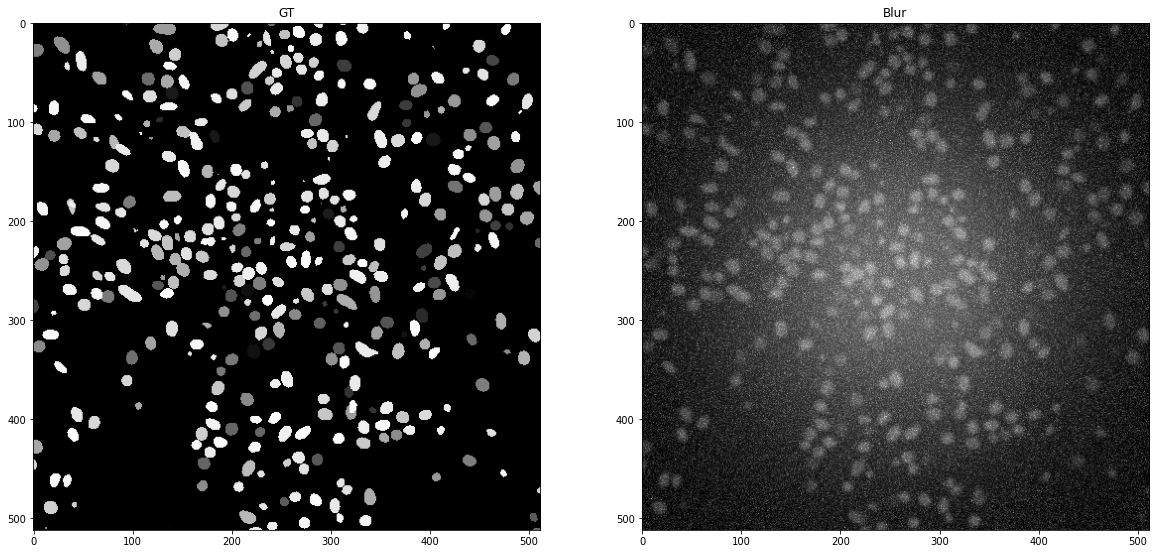

In [8]:
index = np.random.randint(0,im_conv_noise.shape[1])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(im[0,index], cmap='gray')
plt.title('GT')
plt.subplot(1,2,2)
plt.imshow(im_conv_noise[0,index], cmap='gray')
plt.title('Blur')
plt.show()

In [9]:
def get_SSIM(gt, pred):
    mean_pred = torch.mean(pred)
    mean_gt = torch.mean(gt)
    sigma_pred = torch.mean(torch.square(pred - mean_pred))
    sigma_gt = torch.mean(torch.square(gt - mean_gt))
    sigma_cross = torch.mean((pred - mean_pred) * (gt - mean_gt))

    SSIM_1 = 2 * mean_pred * mean_gt + 1e-4
    SSIM_2 = 2 * sigma_cross + 9e-4
    SSIM_3 = torch.square(mean_pred) + torch.square(mean_gt) + 1e-4
    SSIM_4 = sigma_pred + sigma_gt + 9e-4
    SSIM = (SSIM_1*SSIM_2)/(SSIM_3*SSIM_4)

    return SSIM

In [10]:
from torch.utils import data

# NCDHW
# assumption is to use 8x64x64 (DHW) slices to train
# the input z-stacks are 96x512x512 (DWH)

# 144x512x512
# 48x512x512

class ImageLoader(data.Dataset):
    def __init__(self, gt, blur, test=False):
        self.gt = gt
        self.blur = blur

        if test:
            self.len = 18 * 8 * 8
        else:
            self.len = 6 * 8 * 8

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        z = index // 64 # depth selector
        
        t = index - 64*z
        x = t//8
        y = t%8

        blur = self.blur[:,z*8:(z+1)*8,x*64:(x+1)*64,y*64:(y+1)*64]
        gt = self.gt[:,z*8:(z+1)*8,x*64:(x+1)*64,y*64:(y+1)*64]

        return blur, gt

In [11]:
import torch
from torch import nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def softplus(x):
    # return torch.log(torch.exp(x) + 1)
    return nn.ReLU()(x)

class RLN(nn.Module):
    def __init__(self):
        super(RLN, self).__init__()


        # h1 branch
        self.h1_avg_pool = torch.nn.AvgPool3d([2,2,2], stride=[2,2,2])
        self.h1_conv1 = torch.nn.Conv3d(in_channels=2, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same', bias=False)
        self.h1_bn1 = torch.nn.BatchNorm3d(4)
        self.h1_conv2 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn2 = torch.nn.BatchNorm3d(4)
        self.h1_conv3 = torch.nn.Conv3d(in_channels=8, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn3 = torch.nn.BatchNorm3d(4)

        self.h1_bnA = torch.nn.BatchNorm3d(2)
        
        self.h1_conv4 = torch.nn.Conv3d(in_channels=2, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn4 = torch.nn.BatchNorm3d(8)
        self.h1_conv5 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn5 = torch.nn.BatchNorm3d(8)
        self.h1_conv6 = torch.nn.Conv3d(in_channels=16, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn6 = torch.nn.BatchNorm3d(8)

        self.h1_convup = torch.nn.ConvTranspose3d(in_channels=8, out_channels=4, kernel_size=[2,2,2], stride=[2,2,2])
        self.h1_bnB = torch.nn.BatchNorm3d(4)
        
        self.h1_conv7 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h1_bn7 = torch.nn.BatchNorm3d(4)

        self.h1_bnC = torch.nn.BatchNorm3d(1)


        # h2 branch
        self.h2_conv1 = torch.nn.Conv3d(in_channels=2, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn1 = torch.nn.BatchNorm3d(4)
        self.h2_conv2 = torch.nn.Conv3d(in_channels=4, out_channels=4, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn2 = torch.nn.BatchNorm3d(4)
        
        self.h2_bnA = torch.nn.BatchNorm3d(2)

        self.h2_conv3 = torch.nn.Conv3d(in_channels=2, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn3 = torch.nn.BatchNorm3d(8)
        self.h2_conv4 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h2_bn4 = torch.nn.BatchNorm3d(8)

        self.h2_bnB = torch.nn.BatchNorm3d(1)


        # h3 branch
        self.h3_conv1 = torch.nn.Conv3d(in_channels=1, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_conv2 = torch.nn.Conv3d(in_channels=10, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_conv3 = torch.nn.Conv3d(in_channels=16, out_channels=8, kernel_size=[3,3,3], stride=[1,1,1], padding='same')
        self.h3_bnA = torch.nn.BatchNorm3d(8)

    #     self.apply(self._init_weights)

    # def _init_weights(self, module):
    #     if isinstance(module, nn.Linear):
    #         module.weight.data.normal_(mean=0.0, std=1.0)
    #         if module.bias is not None:
    #             module.bias.data.zero_()

    def forward(self, y):

        def check(x, n):
            if torch.sum(torch.isnan(x)) > 0: 
                print(n, torch.sum(torch.isnan(x)))

        yy = torch.cat([y,y],1)

        # ******** h1 branch ********
        x = self.h1_avg_pool(yy)

        xt = softplus(torch.cat([x,x], 1))

        # =============================================
        # this creates nan

        # FP1
        check(x, 'A')
        x1 = self.h1_conv1(x)
        check(x1, 'B')
        x1 = self.h1_bn1(x1)
        check(x1, 'C')
        x1 = softplus(x1)
        check(x1, 'D')

        check(x1, 1)

        # =============================================

        x2 = self.h1_conv2(x1)
        x2 = self.h1_bn2(x2)
        x2 = softplus(x2)

        check(x2, 2)

        xx = torch.cat([x1,x2], 1)

        x3 = self.h1_conv3(xx)
        x3 = self.h1_bn3(x3)
        x3 = softplus(x3) + xt

        check(x3, 3)

        # C_AVE
        xy = torch.mean(x3, dim=1, keepdim=True)
        xy = torch.cat([xy,xy], 1)

        # DV1
        xy = (x)/(xy + 0.001)
        xy = self.h1_bnA(xy)

        check(xy, 33)

        # BP1
        x4 = self.h1_conv4(xy)
        x4 = self.h1_bn4(x4)
        x4 = softplus(x4)

        check(x4, 4)

        x5 = self.h1_conv5(x4)
        x5 = self.h1_bn5(x5)
        x5 = softplus(x5)

        check(x5, 5)

        xx = torch.cat([x4,x5], 1)

        x6 = self.h1_conv6(xx)
        x6 = self.h1_bn6(x6)
        x6 = softplus(x6)

        check(x6, 6)

        # BP1_up
        xu = self.h1_convup(x6)
        xu = self.h1_bnB(xu)
        xu = softplus(xu)

        check(xu, 66)

        x7 = self.h1_conv7(xu)
        x7 = self.h1_bn7(x7)
        x7 = softplus(x7)

        check(x7, 7)

        # C_AVE
        xz = torch.mean(x7, dim=1, keepdim=True)        

        # E1
        temp = xz * y # <--- use for loss

        xq = self.h1_bnC(temp)
        e1 = softplus(xq)

        check(e1, 77)

        # ******** h2 branch ********
        # FP2
        y1 = self.h2_conv1(yy)
        y1 = self.h2_bn1(y1)
        y1 = softplus(y1)

        y2 = self.h2_conv2(y1)
        y2 = self.h2_bn2(y2)
        y2 = softplus(y2)

        # C_AVE
        yq = torch.mean(y2, dim=1, keepdim=True)
        yq = torch.cat([yq,yq], 1)

        # DV2
        yq = (yy)/(yq + 0.001)
        yq = self.h2_bnA(yq)
        
        # BP2
        y3 = self.h2_conv3(yq)
        y3 = self.h2_bn3(y3)
        y3 = softplus(y3)

        y4 = self.h2_conv4(y3)
        y4 = self.h2_bn4(y4)
        y4 = softplus(y4) + torch.ones(y4.shape).to(device)

        # E2
        yz = torch.mean(y4, dim=1, keepdim=True)

        yz = e1 * yz
        yz = self.h2_bnB(yz)
        e2 = softplus(yz)

        # ******** h3 branch ********
        z1 = self.h3_conv1(e2)
        z1 = softplus(z1)
        zz1 = torch.cat([z1,e2,e1], 1)

        z2 = self.h3_conv2(zz1)
        z2 = softplus(z2)

        m = torch.cat([z1,z2], 1)
        z3 = self.h3_conv3(m)
        z3 = self.h3_bnA(z3)
        z3 = softplus(z3)

        ef = torch.mean(z3, dim=1, keepdim=True)

        return ef, temp

In [12]:
from torch.utils.data import DataLoader

train_gt_data = torch.from_numpy(im[:,:144,:,:])
train_blur_data = torch.from_numpy(im_conv_noise[:,:144,:,:])

val_gt_data = torch.from_numpy(im[:,144:,:,:])
val_blur_data = torch.from_numpy(im_conv_noise[:,144:,:,:])

rln_train = ImageLoader(train_gt_data, train_blur_data)
rln_train_dataloader = DataLoader(rln_train, batch_size=4, shuffle=True)

rln_val = ImageLoader(val_gt_data, val_blur_data)
rln_val_dataloader = DataLoader(rln_val, batch_size=1, shuffle=True)

In [13]:
net = RLN().to(device)

opt = torch.optim.NAdam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
mse_loss = nn.MSELoss()

 -- Staring training epoch 1 --
train loss: 0.315872958301051
validation loss: 0.20945694932554212


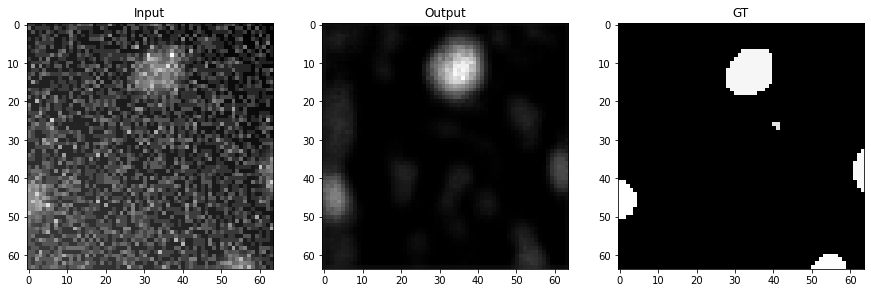

 -- Staring training epoch 2 --
train loss: 0.19775658063588883
validation loss: 0.25326212027796996


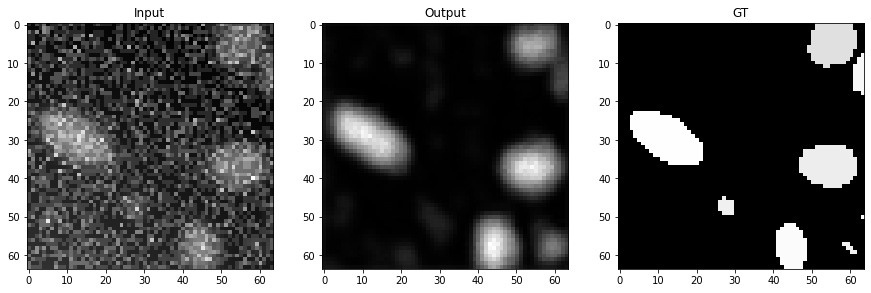

 -- Staring training epoch 3 --
train loss: 0.16033953735874132
validation loss: 0.1293279702591764


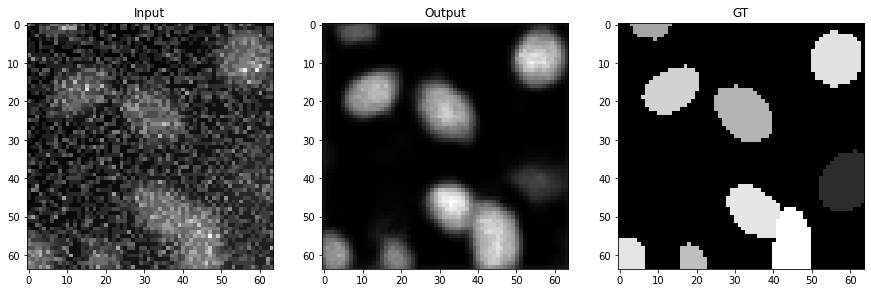

 -- Staring training epoch 4 --
train loss: 0.14220368734622915
validation loss: 0.245840702451512


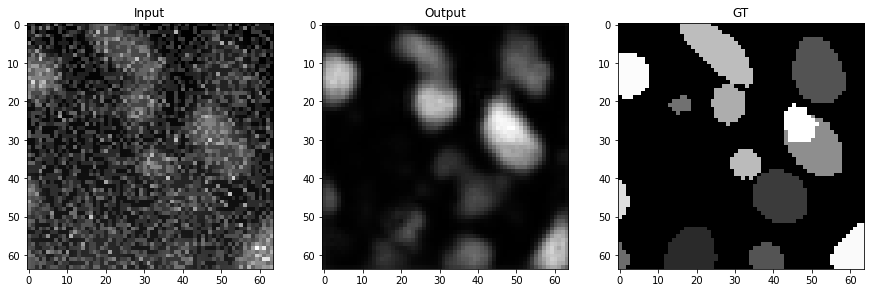

 -- Staring training epoch 5 --
train loss: 0.1406647160933044
validation loss: 0.14642179633038085


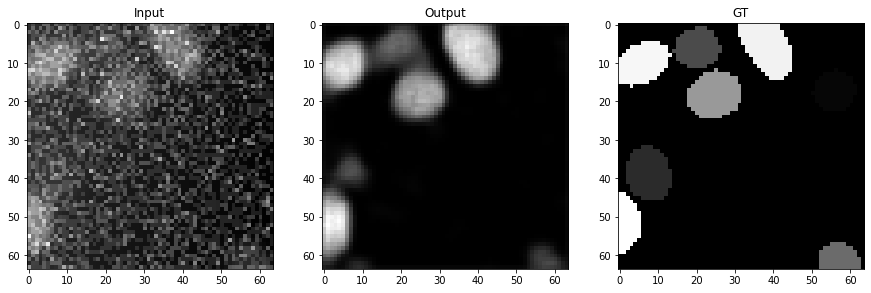

 -- Staring training epoch 6 --
train loss: 0.13673919971627047
validation loss: 0.16067870158004924


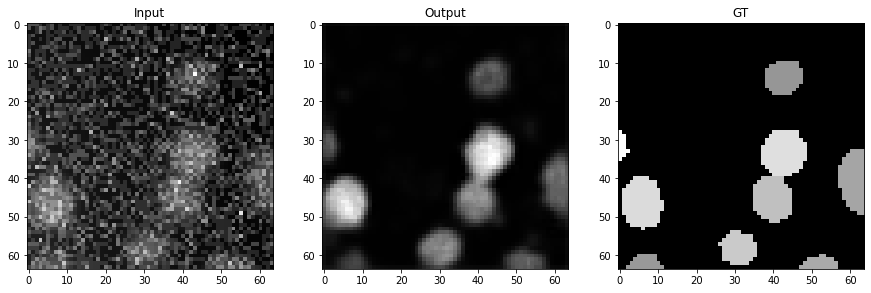

 -- Staring training epoch 7 --
train loss: 0.14676550503680522
validation loss: 0.10729502335479331


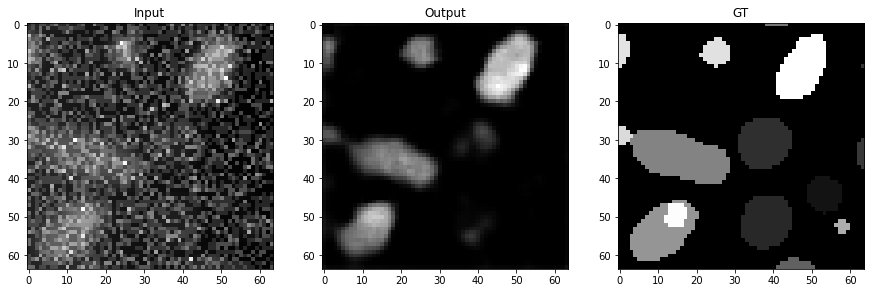

 -- Staring training epoch 8 --
train loss: 0.1424138782661234
validation loss: 0.3298066682523458


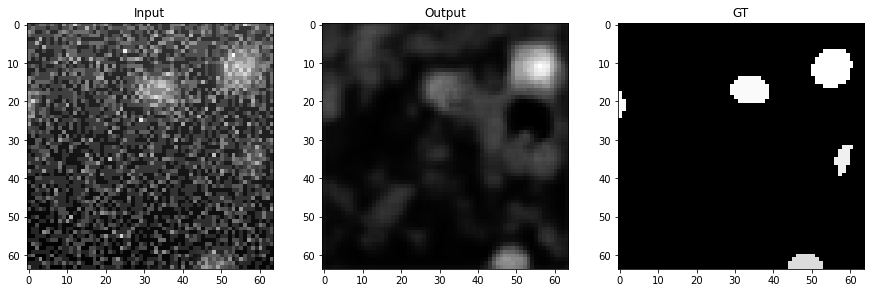

 -- Staring training epoch 9 --
train loss: 0.1251671607941449
validation loss: 0.31398468945921704


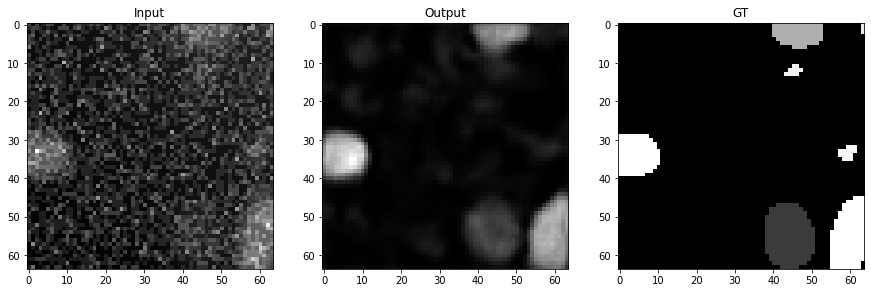

 -- Staring training epoch 10 --
train loss: 0.11291216369598754
validation loss: 0.09144738596954623


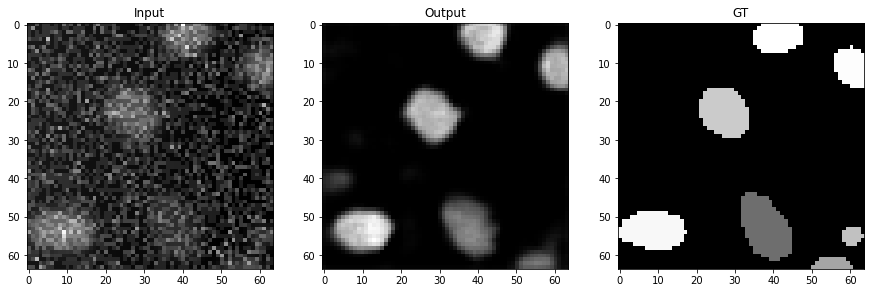

 -- Staring training epoch 11 --
train loss: 0.12185007314578887
validation loss: 0.11273003900049065


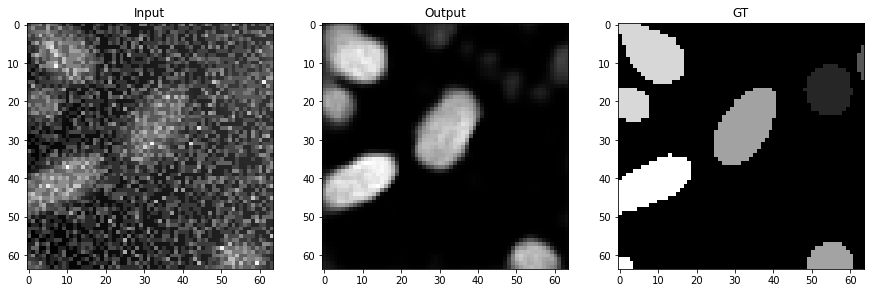

 -- Staring training epoch 12 --
train loss: 0.13150141114130756
validation loss: 0.09348855676634636


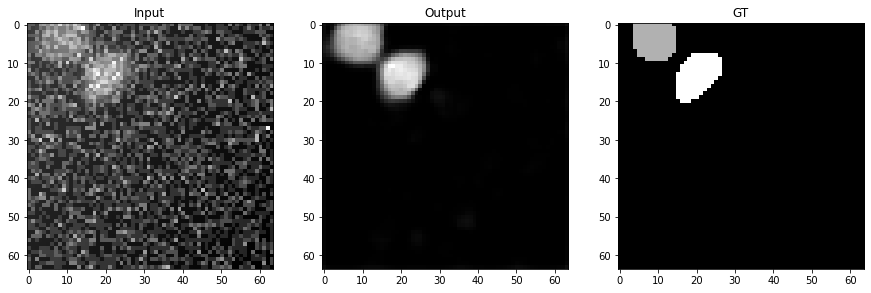

 -- Staring training epoch 13 --
train loss: 0.10157327121156069
validation loss: 0.08798717737533096


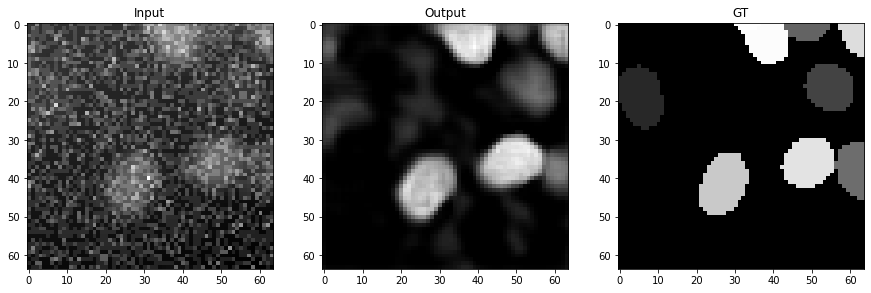

 -- Staring training epoch 14 --
train loss: 0.11420411528190162
validation loss: 0.09338212916042259


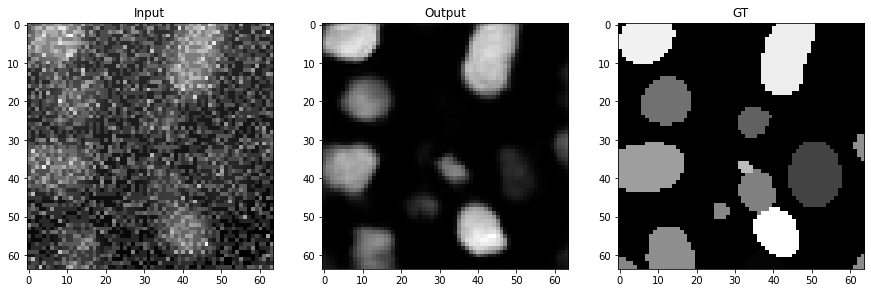

 -- Staring training epoch 15 --
train loss: 0.11496790360059424
validation loss: 0.0815949672889671


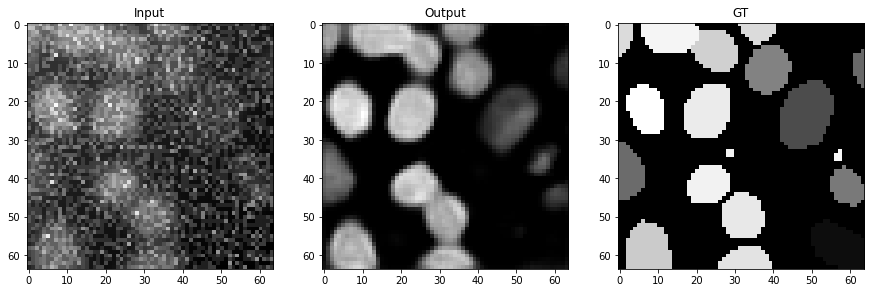

 -- Staring training epoch 16 --
train loss: 0.11821520133627249
validation loss: 0.08259719937879877


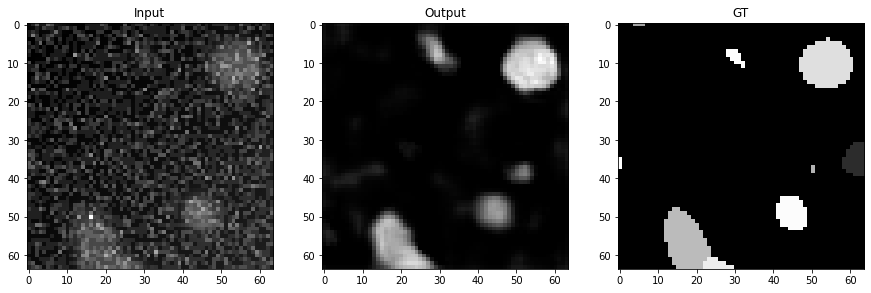

 -- Staring training epoch 17 --
train loss: 0.10624592374183599
validation loss: 0.08335645585804952


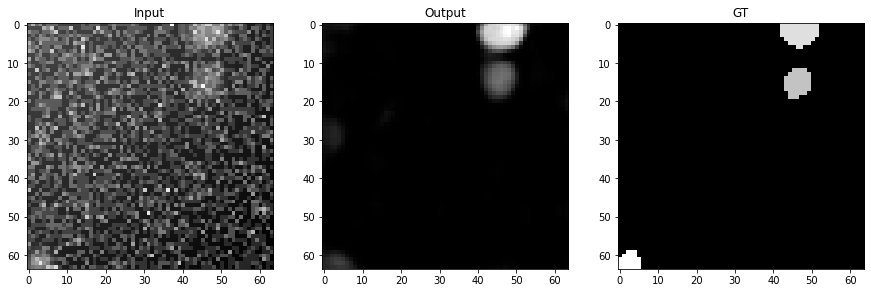

 -- Staring training epoch 18 --
train loss: 0.10213052557384024
validation loss: 0.08902755081990964


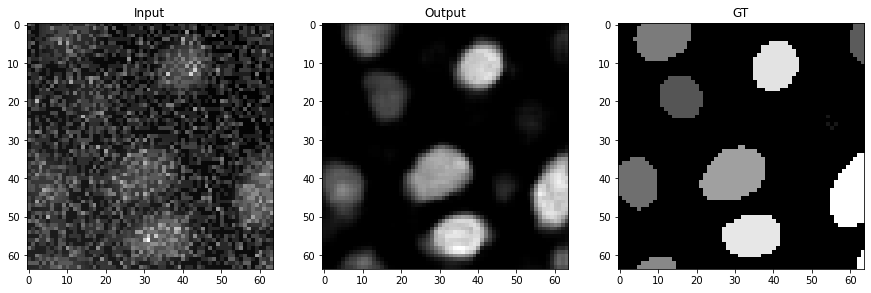

 -- Staring training epoch 19 --
train loss: 0.09358238914962326
validation loss: 0.08030950444576077


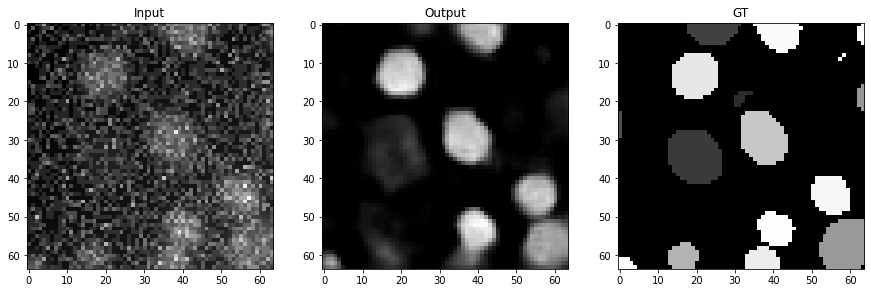

 -- Staring training epoch 20 --
train loss: 0.1084550723448267
validation loss: 0.08053620621152148


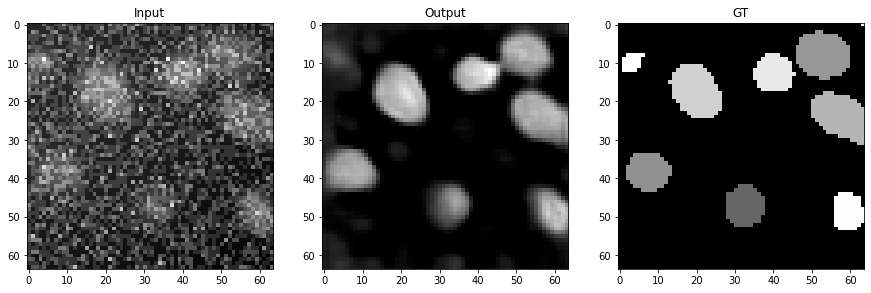

 -- Staring training epoch 21 --
train loss: 0.09160914764722339
validation loss: 0.07931310201283293


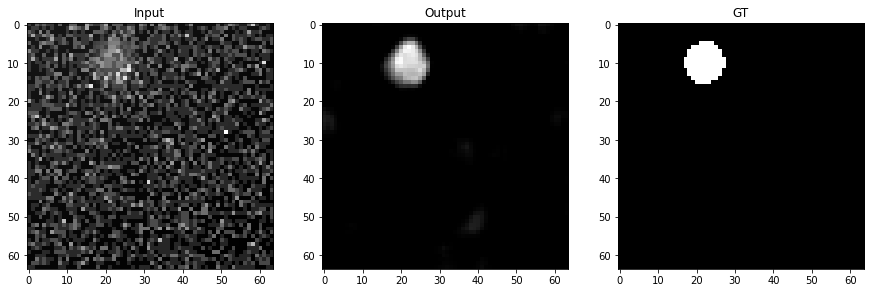

 -- Staring training epoch 22 --
train loss: 0.08928808064957978
validation loss: 0.08409838432439061


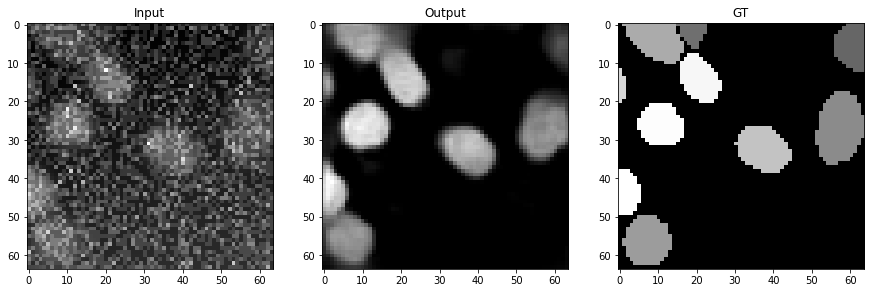

 -- Staring training epoch 23 --
train loss: 0.11422331160143191
validation loss: 0.09076792185019762


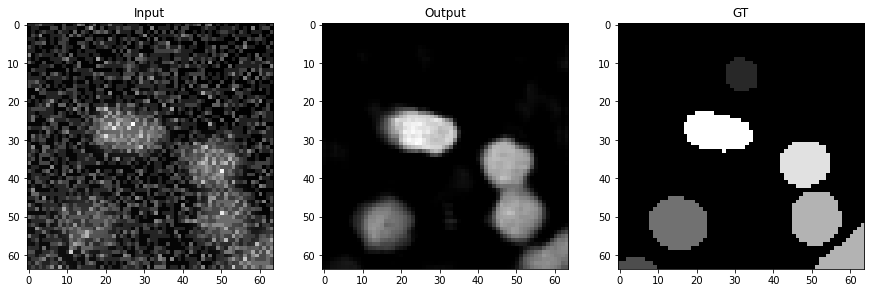

 -- Staring training epoch 24 --
train loss: 0.10210758696245976
validation loss: 0.08504751361968939


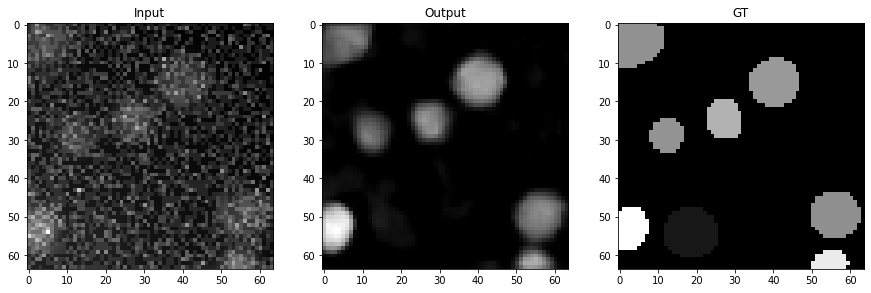

 -- Staring training epoch 25 --
train loss: 0.09755753194326151
validation loss: 0.09156676490583943


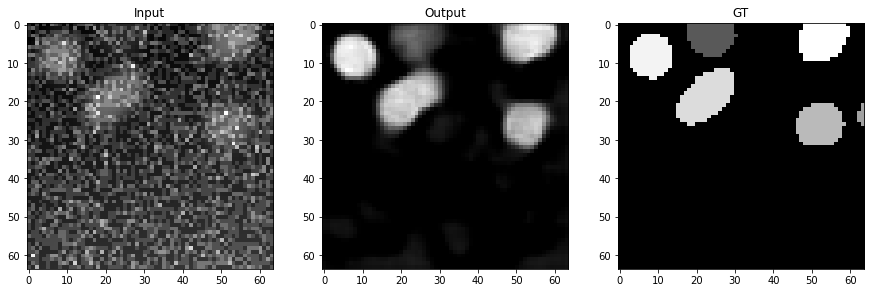

 -- Staring training epoch 26 --
train loss: 0.10839768150921107
validation loss: 0.10072940343503457


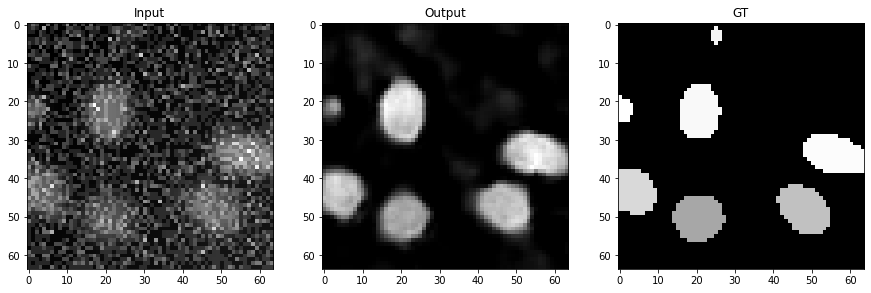

 -- Staring training epoch 27 --
train loss: 0.08658739795778624
validation loss: 0.07795922580782992


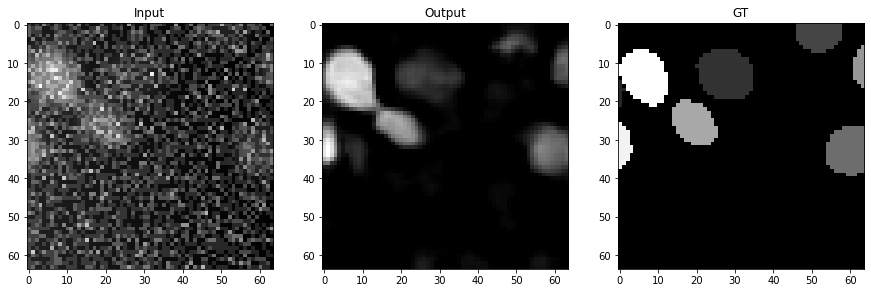

 -- Staring training epoch 28 --
train loss: 0.11037007637441716
validation loss: 0.19086844051681776


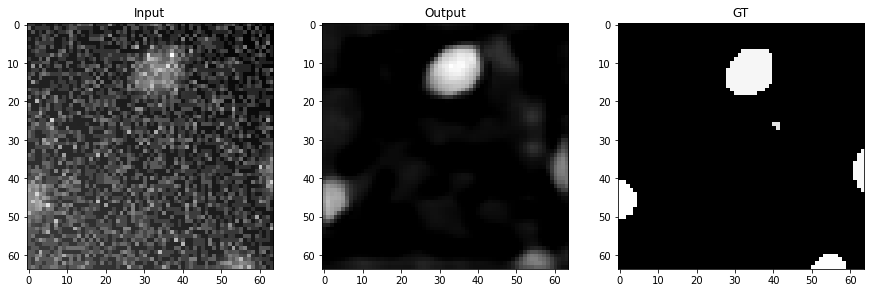

 -- Staring training epoch 29 --
train loss: 0.1053782295740978
validation loss: 0.07988542537005931


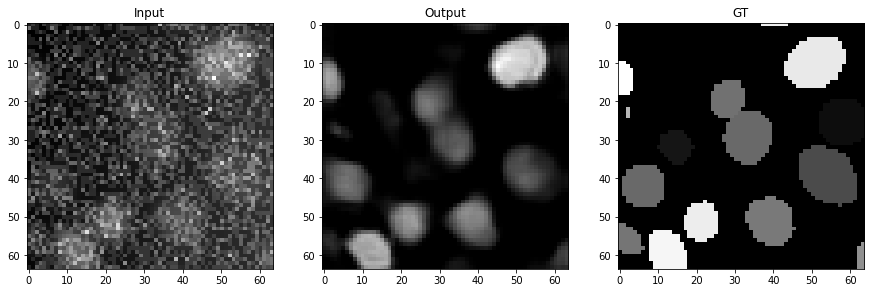

 -- Staring training epoch 30 --
train loss: 0.08613378760651073
validation loss: 0.09338663746076559


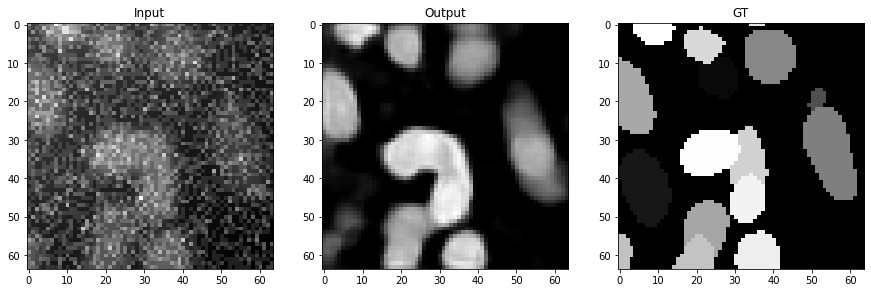

 -- Staring training epoch 31 --
train loss: 0.08519699614502159
validation loss: 0.2723475504405492


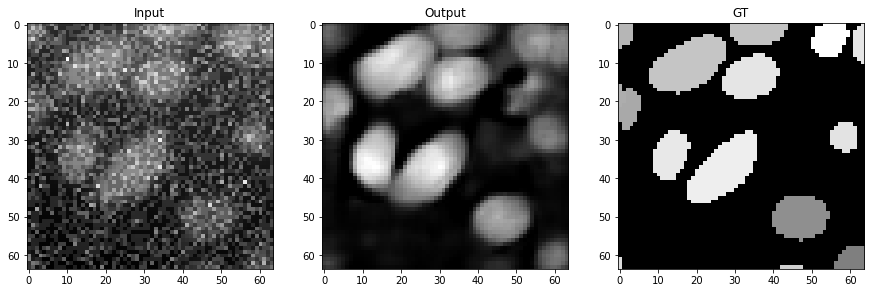

 -- Staring training epoch 32 --
train loss: 0.0858309777304175
validation loss: 0.07237703910408584


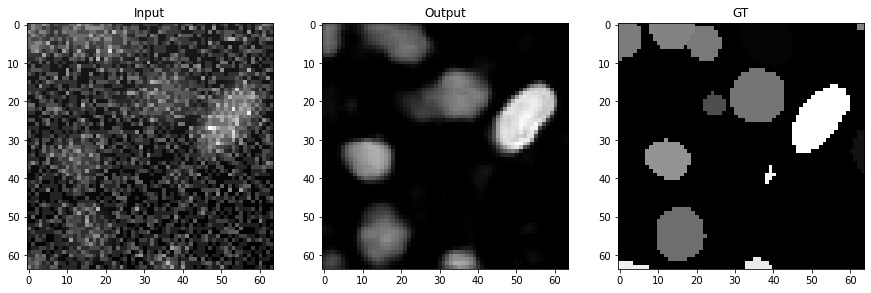

 -- Staring training epoch 33 --
train loss: 0.08429193747029289
validation loss: 0.07319967912043025


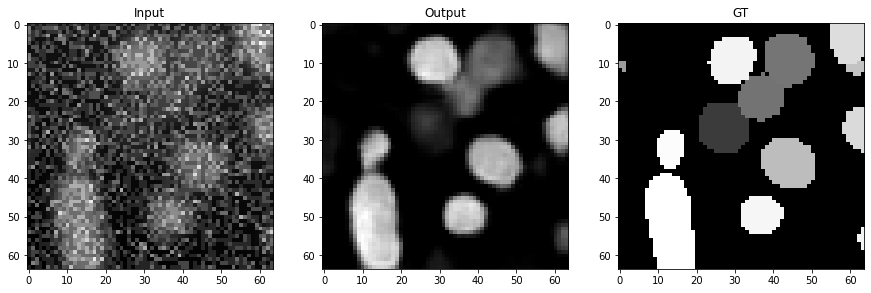

 -- Staring training epoch 34 --
train loss: 0.09361597427254387
validation loss: 0.6563593892914215


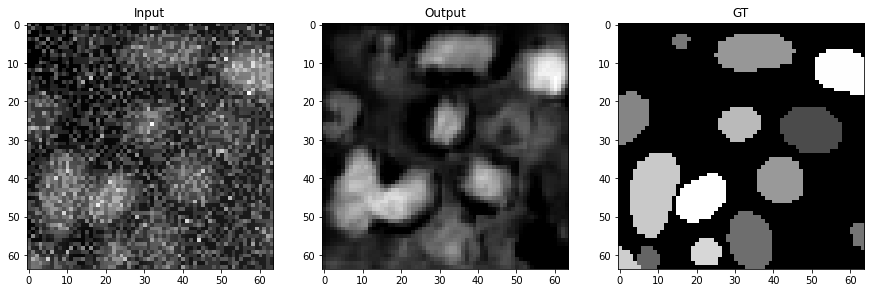

 -- Staring training epoch 35 --
train loss: 0.09644452746988692
validation loss: 0.085499620446435


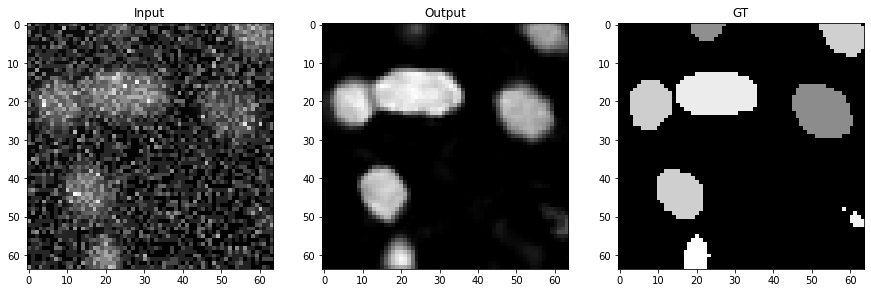

 -- Staring training epoch 36 --
train loss: 0.08812781070300024
validation loss: 0.08032432277789865


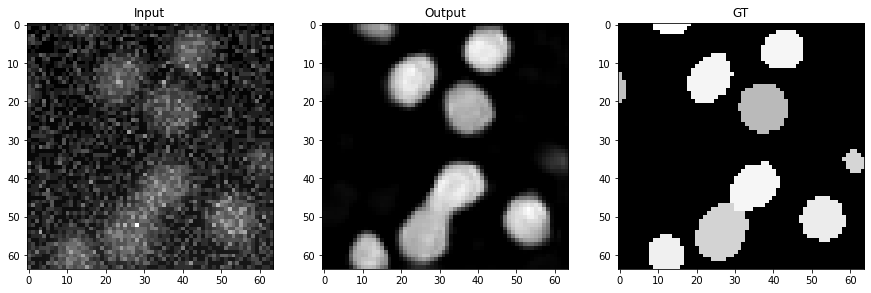

 -- Staring training epoch 37 --
train loss: 0.08204870097147092
validation loss: 0.08088872515483277


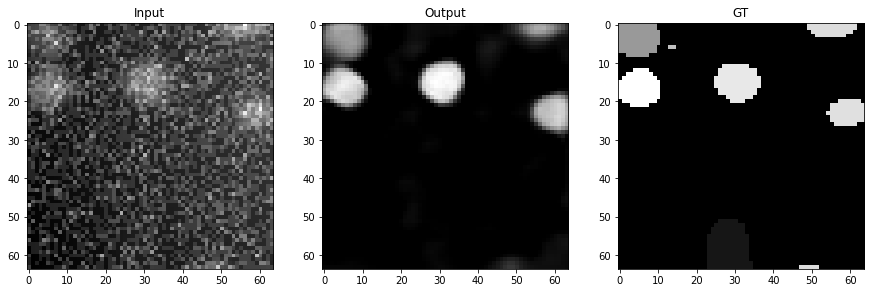

 -- Staring training epoch 38 --
train loss: 0.08456628631039176
validation loss: 0.07724440223875058


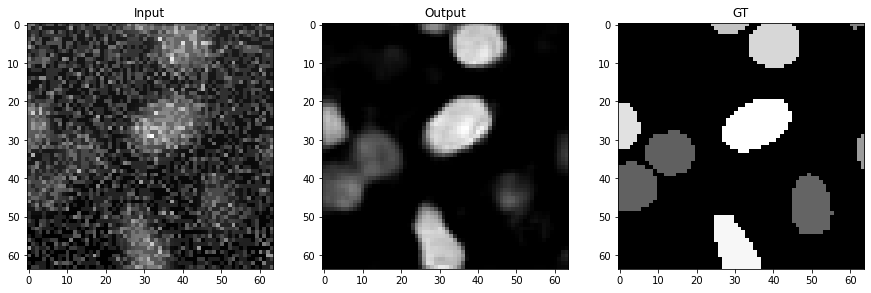

 -- Staring training epoch 39 --
train loss: 0.08807426458196103
validation loss: 0.07987397723148831


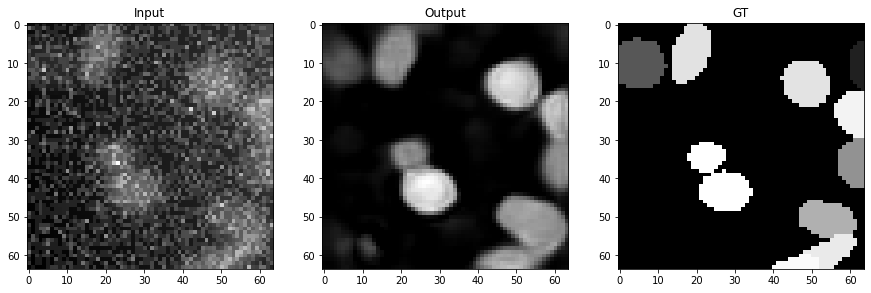

 -- Staring training epoch 40 --
train loss: 0.0810318170198336
validation loss: 0.07671977420777056


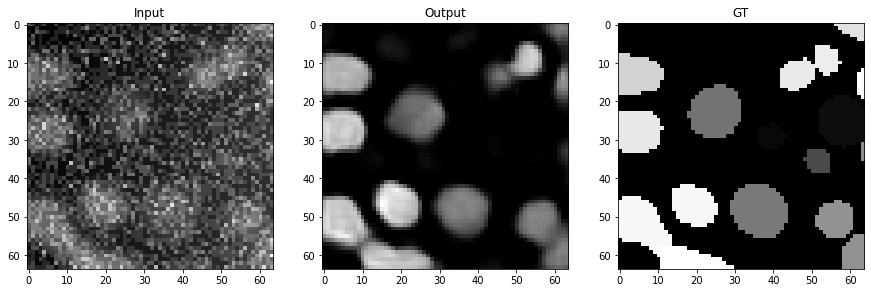

 -- Staring training epoch 41 --
train loss: 0.08710553282741325
validation loss: 0.15078984121781266


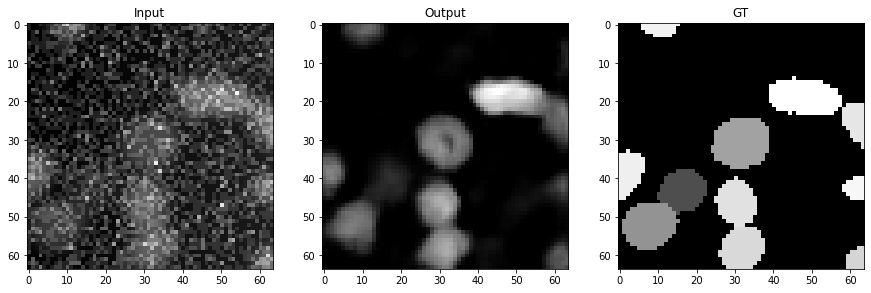

 -- Staring training epoch 42 --
train loss: 0.10044101020526142
validation loss: 0.07494395750937333


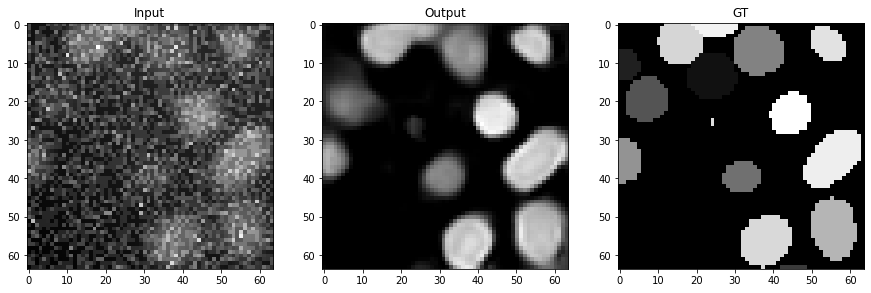

 -- Staring training epoch 43 --
train loss: 0.08640113388591135
validation loss: 0.08296488661833375


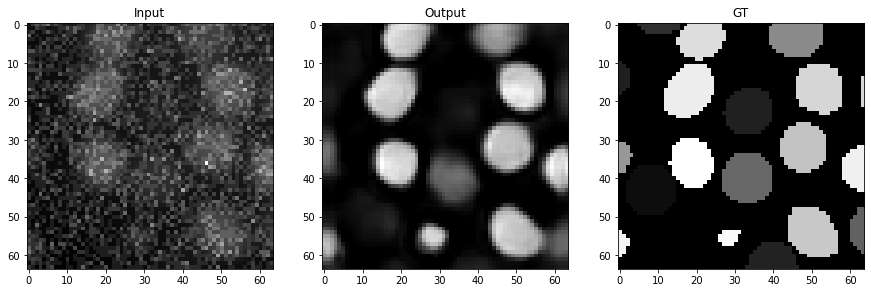

 -- Staring training epoch 44 --
train loss: 0.0786767980954194
validation loss: 0.0811936955598218


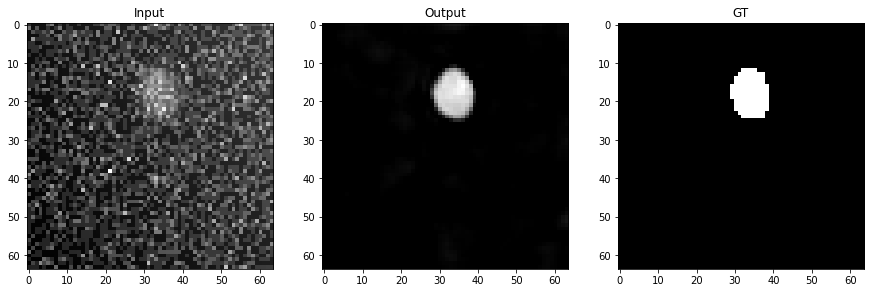

 -- Staring training epoch 45 --
train loss: 0.07938683622968935
validation loss: 0.07656431563568154


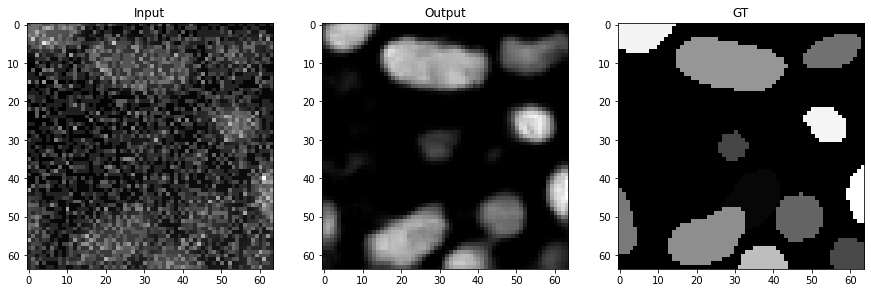

 -- Staring training epoch 46 --
train loss: 0.07950516322329683
validation loss: 0.08326647438675121


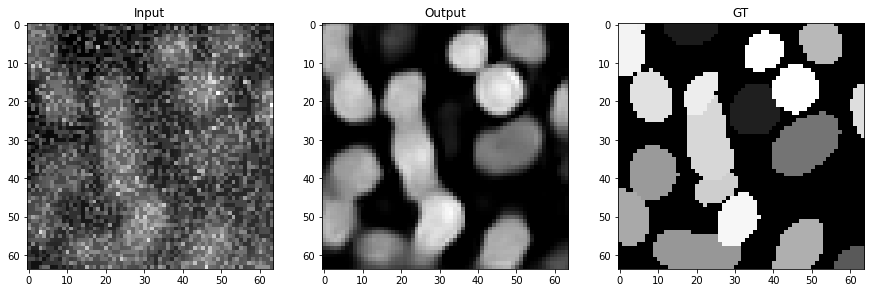

 -- Staring training epoch 47 --
train loss: 0.07758690346254198
validation loss: 0.07012684702885469


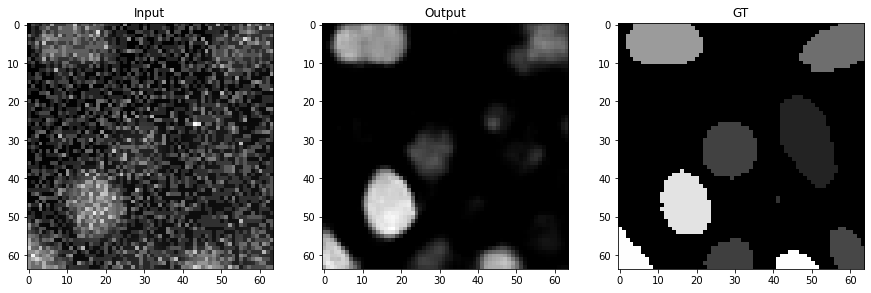

 -- Staring training epoch 48 --
train loss: 0.08757562380462602
validation loss: 0.07273555833890848


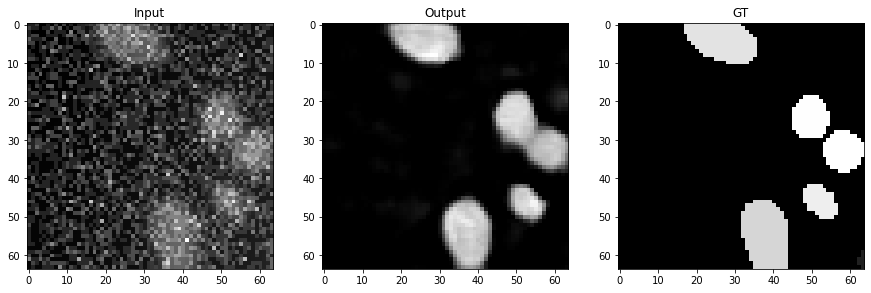

 -- Staring training epoch 49 --
train loss: 0.0762122453349759
validation loss: 0.12184349344336881


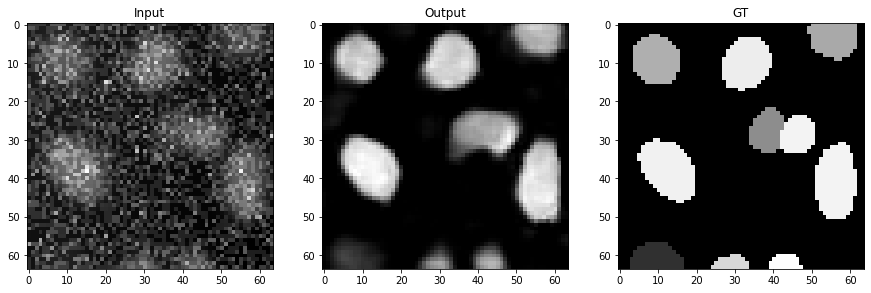

 -- Staring training epoch 50 --
train loss: 0.08303826700052945
validation loss: 0.09176380262662225


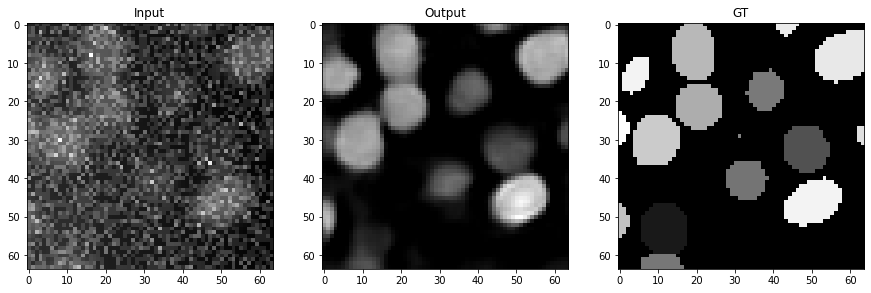

In [14]:
epochs = 50

for epoch in range(epochs):

    print(' -- Staring training epoch {} --'.format(epoch + 1))

    net.train()
    train_loss = []
    for x, y in rln_train_dataloader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        
        y_hat, y_temp = net(x.float())

        loss_main = mse_loss(y_hat.float(), y.float()) - torch.log((1+get_SSIM(y, y_hat))/2)
        loss_aux = mse_loss(y_temp.float(), y.float()*0.8 + x.float()*0.2)
        loss = loss_main + loss_aux
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    print('train loss: {}'.format(np.mean(np.array(train_loss))))


    net.eval()
    val_loss = []
    for x, y in rln_val_dataloader:
        x, y = x.to(device), y.to(device)

        y_hat, y_temp = net(x.float())

        loss_main = mse_loss(y_hat.float(), y.float()) - torch.log((1+get_SSIM(y, y_hat))/2)
        loss_aux = mse_loss(y_temp.float(), y.float()*0.8 + x.float()*0.2)
        loss = loss_main + loss_aux

        val_loss.append(loss.item())

    print('validation loss: {}'.format(np.mean(np.array(val_loss))))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(x.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.imshow(y_hat.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('Output')
    plt.subplot(1,3,3)
    plt.imshow(y.detach().cpu().numpy()[0,0,0,:,:], cmap='gray')
    plt.title('GT')
    plt.show()

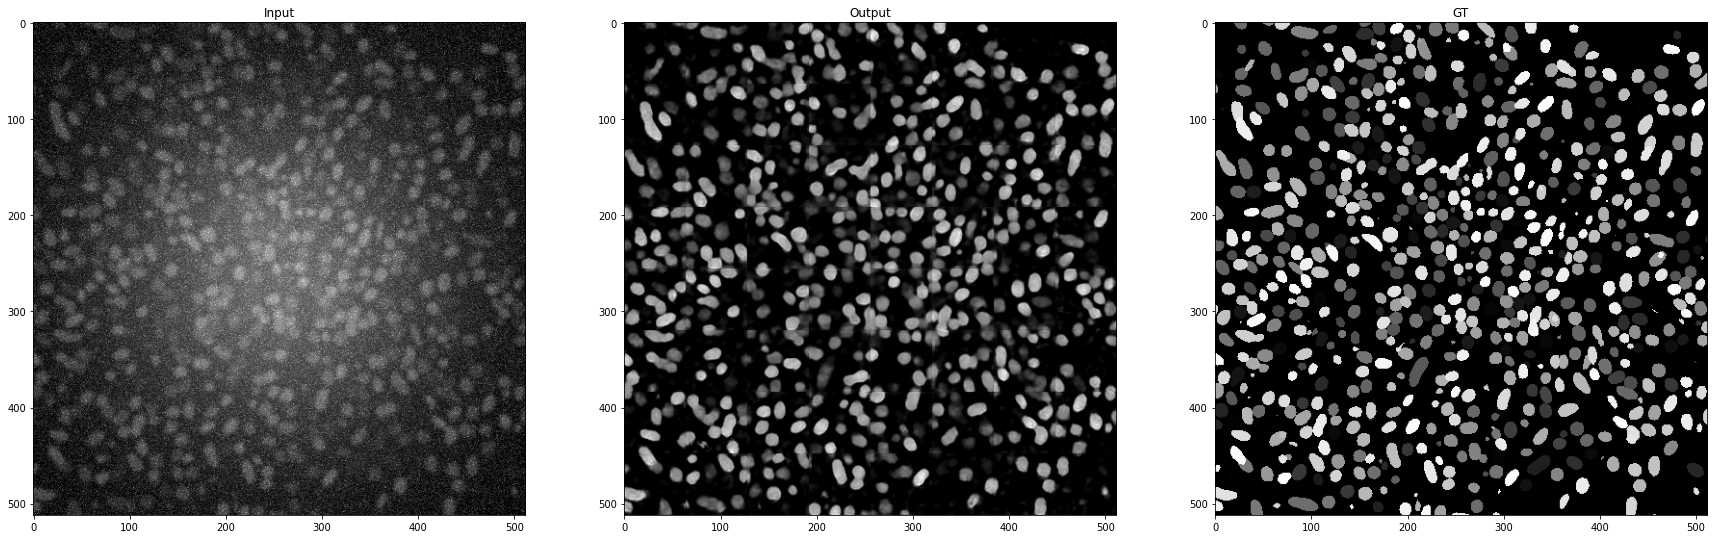

In [15]:
net.eval()

test_stack_gt = val_gt_data[:,:8,:,:].unsqueeze(0).to(device)
test_stack = val_blur_data[:,:8,:,:].unsqueeze(0).to(device)

canvas = np.zeros((512,512))

for i in range(8):
    for j in range(8):
        crop = test_stack[:,:,:,i*64:(i+1)*64,j*64:(j+1)*64]

        out, _ = net(crop.float())
        canvas[i*64:(i+1)*64,j*64:(j+1)*64] = out[0,0,0,:,:].detach().cpu().numpy()

plt.figure(figsize=(30,15))
plt.subplot(1,3,1)
plt.imshow(test_stack[0,0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.title('Input')
plt.subplot(1,3,2)
plt.imshow(canvas, cmap='gray')
plt.title('Output')
plt.subplot(1,3,3)
plt.imshow(test_stack_gt[0,0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.title('GT')
plt.show()

### Test on real data

In [16]:
im_true = tifffile.imread('Knutdata/B11.1_H5.4_frame_000001_Nz100(1).tif', maxworkers=6)

In [24]:
test_true_stack = torch.from_numpy(im_true[50:58,256:-256,256:-256].astype(np.float64)).unsqueeze(0).unsqueeze(0).to(device)
test_true_stack = (test_true_stack - torch.min(test_true_stack))/(torch.max(test_true_stack) - torch.min(test_true_stack))

canvas = np.zeros((512,512))

for i in range(8):
    for j in range(8):
        crop = test_true_stack[:,:,:,i*64:(i+1)*64,j*64:(j+1)*64]

        out, _ = net(crop.float())
        canvas[i*64:(i+1)*64,j*64:(j+1)*64] = out[0,0,0,:,:].detach().cpu().numpy()

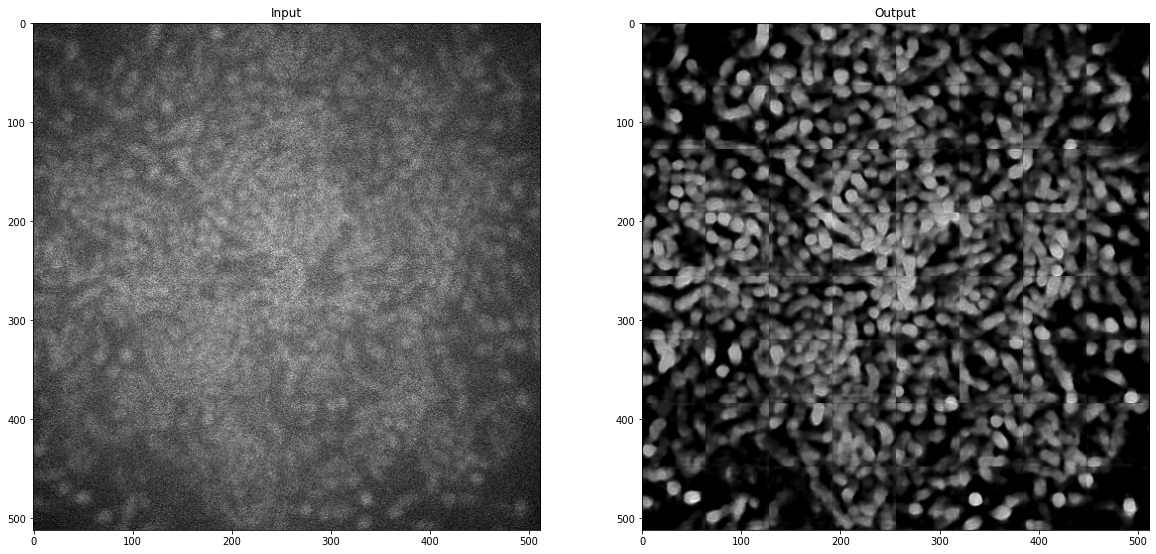

In [26]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(test_true_stack[0,0,0,:,:].detach().cpu().numpy(), cmap='gray')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(canvas, cmap='gray')
plt.title('Output')
plt.show()